<a href="https://colab.research.google.com/github/mortgad/DLVR/blob/main/FairFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FairFace dataset
- Paper: https://openaccess.thecvf.com/content/WACV2021/papers/Karkkainen_FairFace_Face_Attribute_Dataset_for_Balanced_Race_Gender_and_Age_WACV_2021_paper.pdf
- GitHub: https://github.com/joojs/fairface?tab=readme-ov-file


# 1. Loading data

## Loading images

In [1]:
# Step 1: Install PyDrive
!pip install PyDrive

# Step 2: Import the required libraries
import os
import zipfile
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Step 3: Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 4: Specify the file ID from the link
file_id = '1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86'

# Step 5: Download the .zip file
downloaded = drive.CreateFile({'id': file_id})
zip_filename = 'downloaded_file.zip'  # Name of the downloaded zip file
downloaded.GetContentFile(zip_filename)

print(f"{zip_filename} downloaded successfully!")

# Step 6: Create the extracted directory if it doesn't exist
extract_dir = '/content/extracted'
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Step 7: Extract the .zip file into the /content/extracted directory
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"File extracted to {extract_dir}")

downloaded_file.zip downloaded successfully!
File extracted to /content/extracted


## Loading labels

In [147]:
# Step 1: Import the necessary libraries if not already imported
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Step 2: Authenticate and create the PyDrive client (if not already done)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Step 3: Function to download CSV file from Google Drive
def download_csv(file_id, destination):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(destination)
    print(f"Downloaded file saved as {destination}")

# Step 4: File IDs and destinations for Train and Validation labels
train_file_id = '1i1L3Yqwaio7YSOCj7ftgk8ZZchPG7dmH'  # Train labels file ID
val_file_id = '1wOdja-ezstMEp81tX1a-EYkFebev4h7D'    # Validation labels file ID

train_labels_path = '/content/train_labels.csv'
val_labels_path = '/content/val_labels.csv'

# Step 5: Download Train and Validation label CSV files
download_csv(train_file_id, train_labels_path)
download_csv(val_file_id, val_labels_path)

train_df = pd.read_csv(train_labels_path)
val_df = pd.read_csv(val_labels_path)

train_df.head()

Downloaded file saved as /content/train_labels.csv
Downloaded file saved as /content/val_labels.csv


,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


# 2. Data test

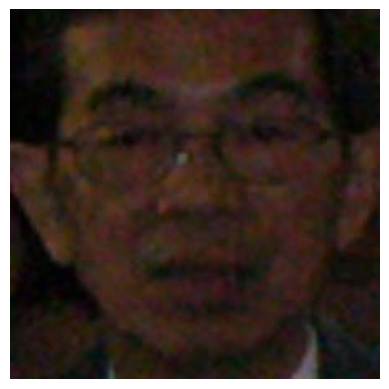

Shape: (224, 224, 3)


In [3]:
import cv2
import matplotlib.pyplot as plt

file_path = '/content/extracted/train/1.jpg'
image = cv2.imread(file_path)

# Convert BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# Print the shape of the image
print(f"Shape: {image.shape}")

# 3. Data preprocessing
- Currently uses train and validations set defined from the original paper -> no need to use data_split later

In [148]:
from pathlib import Path
from tqdm.notebook import tqdm  # For the progress bar (if not already installed, run: !pip install tqdm)

tqdm.pandas()

train_df = train_df.copy()
val_df = val_df.copy()

# Not sure what service_test is
train_df.drop(columns=['service_test'],inplace=True)
val_df.drop(columns=['service_test'],inplace=True)

# Define the base image directory
base_img = Path('/content/extracted')

# Update labels in both train_df and val_df
train_df['age'] = train_df['age'].replace('more than 70', '70+')
val_df['age'] = val_df['age'].replace('more than 70', '70+')

# Update the 'file' column for train and val dataframes
train_df['file'] = train_df['file'].progress_map(lambda x: base_img / x)
val_df['file'] = val_df['file'].progress_map(lambda x: base_img / x)

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [149]:
###### Mapping gender
gender_map = {'Male': 0, 'Female': 1}

train_df['gender_code'] = train_df['gender'].progress_map(lambda x:gender_map[x])
val_df['gender_code'] = val_df['gender'].progress_map(lambda x:gender_map[x])

###### Mapping age
age_order = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']

# Setting the desired order
train_df['age'] = train_df['age'].astype('category')
train_df['age'] = train_df['age'].cat.set_categories(age_order, ordered=True)

# Encoding the age groups
train_df['age_code'] = train_df['age'].cat.codes

# Creating the age map
age_map = dict(zip(train_df['age'].cat.categories, range(len(train_df['age'].cat.categories))))
val_df['age_code'] = val_df['age'].progress_map(lambda x: age_map[x])

###### Mapping race
train_df['race'] = train_df['race'].astype('category')
train_df['race_code'] = train_df['race'].cat.codes

race_map = dict(zip(train_df['race'].cat.categories,range(len(train_df['race'].cat.categories))))
val_df['race_code'] = val_df['race'].progress_map(lambda x:race_map[x])

  0%|          | 0/86744 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

In [150]:
train_df.head()

,file,age,gender,race,gender_code,age_code,race_code
0,/content/extracted/train/1.jpg,50-59,Male,East Asian,0,6,1
1,/content/extracted/train/2.jpg,30-39,Female,Indian,1,4,2
2,/content/extracted/train/3.jpg,3-9,Female,Black,1,1,0
3,/content/extracted/train/4.jpg,20-29,Female,Indian,1,3,2
4,/content/extracted/train/5.jpg,20-29,Female,Indian,1,3,2


In [151]:
# TESTING PURPOSES ONLY
train_df = train_df[:1000]
val_df = val_df[:100]

In [152]:
from PIL import Image
import numpy as np

# Lists to store the extracted data
images = []
ages = train_df['age_code'].tolist()  # List of age codes
genders = train_df['gender_code'].tolist()  # List of gender codes
ethnicities = train_df['race_code'].tolist()  # List of race codes

# Loading images based on the file paths in the 'file' column
for img_path in train_df['file']:
    try:
        # Open the image and convert it to a numpy array
        img = Image.open(img_path)
        img = np.array(img)  # Convert to a numpy array (optional, depending on how you want to handle images)
        images.append(img)  # Append the image to the list
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

print("Lists created successfully!")

# Optionally, do the same for the validation dataframe (val_df)
val_images = []
val_ages = val_df['age_code'].tolist()
val_genders = val_df['gender_code'].tolist()
val_ethnicities = val_df['race_code'].tolist()

# Loading validation images
for img_path in val_df['file']:
    try:
        img = Image.open(img_path)
        img = np.array(img)
        val_images.append(img)
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")

print("Validation lists created successfully!")

Lists created successfully!
Validation lists created successfully!


image shape: (224, 224, 3)
age: 6
gender: 0
ethnicity: 1


array([[[ 8,  8, 10],
        [ 9,  9, 11],
        [10,  8, 11],
        ...,
        [45, 26, 20],
        [45, 24, 21],
        [45, 24, 21]],

       [[ 7,  7,  9],
        [ 8,  8, 10],
        [ 9,  7, 10],
        ...,
        [42, 25, 18],
        [41, 23, 19],
        [41, 23, 19]],

       [[ 6,  6,  8],
        [ 6,  6,  8],
        [ 8,  6,  7],
        ...,
        [35, 24, 18],
        [34, 23, 19],
        [34, 23, 19]],

       ...,

       [[42, 25, 31],
        [42, 25, 31],
        [43, 27, 30],
        ...,
        [20, 17, 10],
        [21, 18, 11],
        [20, 20, 10]],

       [[39, 27, 31],
        [39, 27, 31],
        [37, 27, 28],
        ...,
        [21, 18,  9],
        [22, 19, 10],
        [22, 20,  8]],

       [[37, 26, 30],
        [37, 26, 30],
        [35, 26, 27],
        ...,
        [24, 20, 11],
        [23, 21,  9],
        [23, 21,  9]]], dtype=uint8)
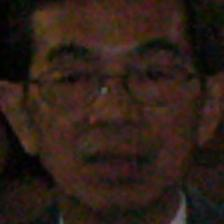

In [153]:
print(f"image shape: {images[0].shape}")
print(f"age: {ages[0]}")
print(f"gender: {genders[0]}")
print(f"ethnicity: {ethnicities[0]}")
images[0]

# 4. EDA

In [154]:
# Get libraries for loading data and plotting subgroups

import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np


# Make one dataframe with all lists:
# Creating DataFrame
df = pd.DataFrame({
    'Age': ages,
    'Gender': genders,
    'Ethnicity': ethnicities
})

print(df.head(1))

# Looking at simple descriptive statistic, which may only be releveant for the numeric collumn age
df.describe()

   Age  Gender  Ethnicity
0    6       0          1


,Age,Gender,Ethnicity
count,1000.00000,1000.000000,1000.000000
mean,3.49100,0.475000,3.091000
std,1.61819,0.499624,2.079674
min,0.00000,0.000000,0.000000
25%,3.00000,0.000000,1.000000
50%,3.00000,0.000000,3.000000
75%,5.00000,1.000000,5.000000
max,8.00000,1.000000,6.000000


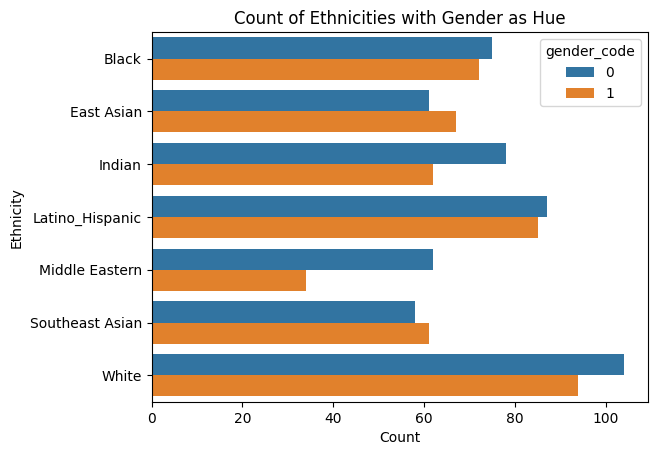

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting race/ethnicity with ethnicity on the y-axis and count on the x-axis
sns.countplot(data=train_df, y='race_code', hue='gender_code')

# Setting the y-axis labels to show the original race names using your race_map
plt.yticks(ticks=range(len(race_map)), labels=race_map.keys())

# Adding plot labels
plt.title("Count of Ethnicities with Gender as Hue")
plt.xlabel("Count")
plt.ylabel("Ethnicity")

# Show the plot
plt.show()

<Axes: xlabel='Gender', ylabel='count'>

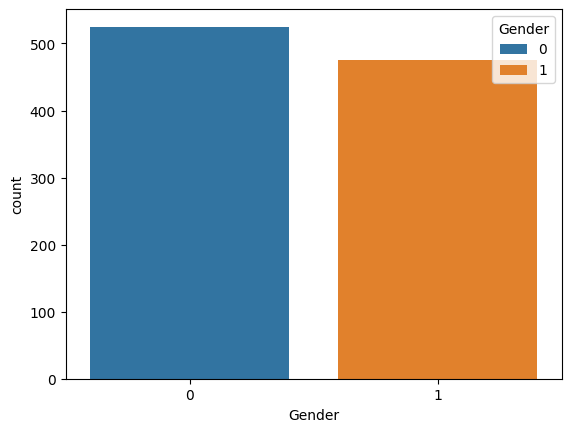

In [156]:
# Then gender distribution is almost perfectly 50/50
sns.countplot(data=df, x ='Gender', hue ='Gender')

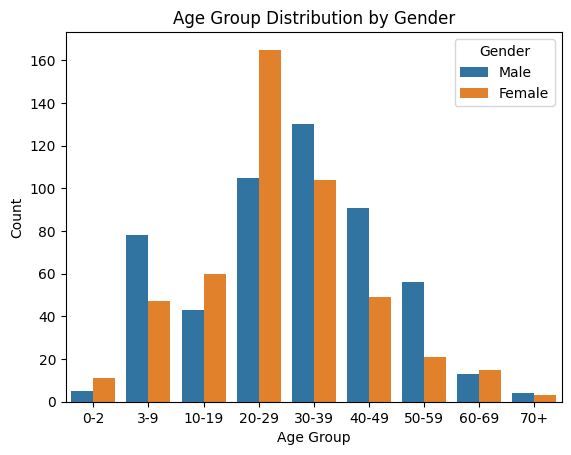

In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution
sns.countplot(data=train_df, x='age', hue='gender_code')

# Setting the legend to show 'Male' and 'Female' instead of 0 and 1
plt.legend(title='Gender', labels=gender_map.keys())

# Adding plot labels
plt.title('Age Group Distribution by Gender')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

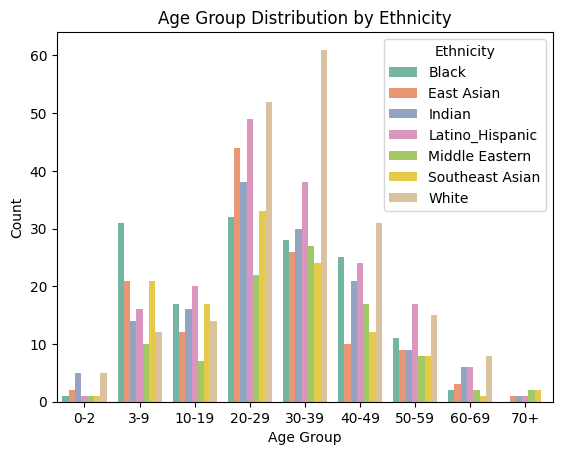

In [158]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Now you can plot the correctly ordered age group distribution by race (ethnicity)
sns.countplot(data=train_df, x='age', hue='race_code', palette='Set2')

# Setting the legend to show ethnicity labels
plt.legend(title='Ethnicity', labels=race_map.keys())

# Adding plot labels
plt.title('Age Group Distribution by Ethnicity')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Show the plot
plt.show()

# 5. Classifier of age

## MobileNet v3

In [88]:
from keras.applications.mobilenet_v3 import preprocess_input  # Update the import for MobileNet
import keras
from keras import layers, models  # Import the required modules

# Preprocess your images using the MobileNet preprocessing
images_preprocessed = preprocess_input(images)

# Now proceed with the MobileNet model using the preprocessed images
conv_base = keras.applications.MobileNetV3Large(
    include_top=False,  # Exclude the top fully connected layers
    weights="imagenet",  # Load pre-trained ImageNet weights
    input_shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]),  # Input shape from the preprocessed images
)

conv_base.trainable = False  # Freeze the pre-trained layers

# Number of classes for target variable
num_classes = len(age_map)

# Train and validation sets
x_train = np.array(images_preprocessed)
y_train = np.array(ages)

x_test = np.array(val_images)
y_test = np.array(val_ages)

print("Conv base, training, and validation sets have been created...")

Conv base, training, and validation sets have been created...


In [89]:
inputs = keras.Input(shape=(images_preprocessed[0].shape[0], images_preprocessed[0].shape[1], images_preprocessed[0].shape[2]))
x = conv_base(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         492,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,493,001 (13.32 MB)

 Trainable params: 496,649 (1.89 MB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [90]:
# Set custom learning rate for RMSProp optimizer
learning_rate = 1e-3  # Adjust as needed
optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
#optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
#optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])

mobilenet_history = model.fit(
    x_train,
    y_train,
    epochs = 10,
    batch_size = 32,
    validation_data = (x_test, y_test))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.1996 - loss: 3.8950 - val_accuracy: 0.3300 - val_loss: 2.2269
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3452 - loss: 2.2216 - val_accuracy: 0.3600 - val_loss: 1.9698
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4344 - loss: 1.7515 - val_accuracy: 0.4200 - val_loss: 1.8596
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4709 - loss: 1.5430 - val_accuracy: 0.2400 - val_loss: 2.1804
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4945 - loss: 1.3980 - val_accuracy: 0.2800 - val_loss: 2.3331
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5930 - loss: 1.0706 - val_accuracy: 0.2900 - val_loss: 2.3244
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5803 - loss: 1.0925 - val_accuracy: 0.4200 - val_loss: 2.2190
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6114 - loss: 1.0450 - val_accuracy: 0.3900 - val_loss:

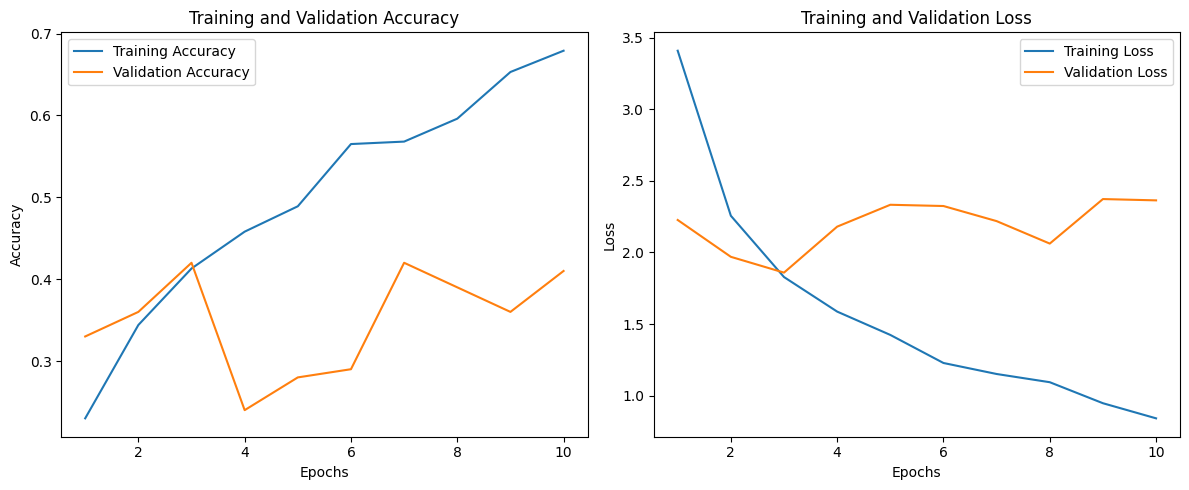

In [91]:
import matplotlib.pyplot as plt

# Get the accuracy and loss data from the history object
accuracy = mobilenet_history.history['accuracy']
val_accuracy = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 790ms/step


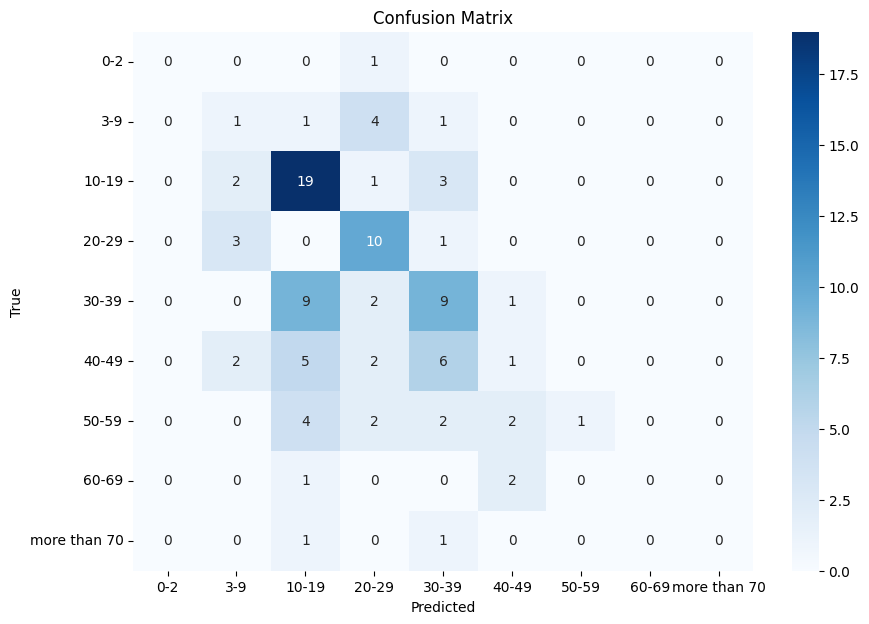

In [146]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Replace with actual model prediction logic, e.g., from a Keras or Scikit-learn model
# Example (for Keras): Assuming you have one-hot encoded predictions
y_pred = model.predict(x_test)  # x_test is your test data
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to sparse integer predictions

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=age_map.keys(), yticklabels=age_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()